
# Лабораторная работа №1 - исследования с алгоритмом KNN (классификация и регрессия)

**Цель:** провести исследование KNN для задач **классификации** и **регрессии**, построить бейзлайны, улучшить их, затем **самостоятельно имплементировать** KNN и сравнить результаты.

---

## Используемые открытые датасеты (доступны по ссылке)

### 1) Классификация - Banknote Authentication (UCI)
Задача: определить, является ли банкнота поддельной (0/1) по числовым признакам, полученным из изображений (wavelet-признаки).  
Ссылка на данные: `https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt`

**Почему этот датасет подходит (реальная задача):**
- прикладная задача антифрода (детекция подделок);
- все признаки числовые → KNN применим напрямую;
- небольшой размер → удобно экспериментировать с кросс-валидацией и перебором гиперпараметров.

### 2) Регрессия - Auto MPG (UCI)
Задача: прогнозировать расход/эффективность топлива (**mpg**) по характеристикам автомобиля.  
Ссылка на данные: `https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data`

**Почему этот датасет подходит (реальная задача):**
- прикладная задача: оценка экономичности и сравнение автомобилей;
- есть числовые признаки разного масштаба → особенно важно улучшение через масштабирование;
- есть пропуски (horsepower = '?') → можно проверить гипотезы про импутацию.

---

## Метрики качества

### Классификация
- **Accuracy** - общая доля правильных ответов (базовая метрика).
- **F1-macro** - баланс precision/recall и одинаковый вес классов.
- **ROC-AUC** - качество ранжирования вероятностей (полезно в антифроде).

### Регрессия
- **MAE** - средняя абсолютная ошибка (в единицах mpg, хорошо интерпретируется).
- **RMSE** - сильнее штрафует большие ошибки.
- **R²** - доля объяснённой дисперсии.

---

> ⚠️ Примечание: результаты могут немного отличаться при других random_state и версиях библиотек.


In [1]:

import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Literal

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    mean_absolute_error, root_mean_squared_error, r2_score
)

import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def rmse(y_true, y_pred) -> float:
    # Не используем squared=... чтобы избежать deprecation warning в новых версиях sklearn
    return float(np.sqrt(root_mean_squared_error(y_true, y_pred)))

pd.set_option("display.max_columns", 50)


## 1. Загрузка данных (по ссылке)

Ниже - загрузка обоих датасетов напрямую из UCI по URL.

In [2]:

# ===== Классификация: Banknote Authentication =====
banknote_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
banknote_cols = ["variance", "skewness", "curtosis", "entropy", "class"]
df_cls = pd.read_csv(banknote_url, header=None, names=banknote_cols)

# ===== Регрессия: Auto MPG =====
auto_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
auto_cols = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin", "car_name"]
df_reg = pd.read_csv(
    auto_url,
    delim_whitespace=True,
    header=None,
    names=auto_cols,
    na_values="?"
)

display(df_cls.head())
display(df_reg.head())

print("Banknote shape:", df_cls.shape)
print("Auto MPG shape:", df_reg.shape)
print("\nПропуски (Auto MPG):")
display(df_reg.isna().sum().to_frame("missing"))


C:\Users\zerotonyq\AppData\Local\Temp\ipykernel_2136\2497005948.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_reg = pd.read_csv(


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


Banknote shape: (1372, 5)
Auto MPG shape: (398, 9)

Пропуски (Auto MPG):


,missing
mpg,0
cylinders,0
displacement,0
horsepower,6
weight,0
acceleration,0
model_year,0
origin,0
car_name,0


## 1.1 Краткий анализ и визуализация данных

Базовая статистика и несколько графиков для формирования гипотез улучшения.

=== Banknote describe ===


,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


=== Auto MPG describe (numeric) ===


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


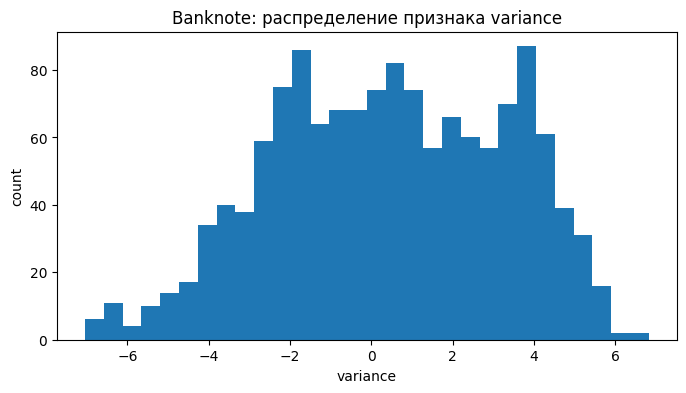

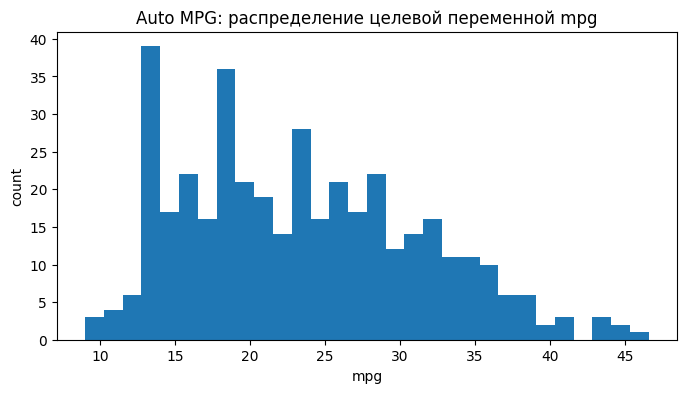

In [3]:

print("=== Banknote describe ===")
display(df_cls.describe())

print("=== Auto MPG describe (numeric) ===")
display(df_reg.drop(columns=["car_name"]).describe())

fig = plt.figure(figsize=(8, 4))
plt.hist(df_cls["variance"], bins=30)
plt.title("Banknote: распределение признака variance")
plt.xlabel("variance")
plt.ylabel("count")
plt.show()

fig = plt.figure(figsize=(8, 4))
plt.hist(df_reg["mpg"].dropna(), bins=30)
plt.title("Auto MPG: распределение целевой переменной mpg")
plt.xlabel("mpg")
plt.ylabel("count")
plt.show()


## 2. Создание бейзлайна и оценка качества (sklearn)

### 2.1 Разбиение на train/test

Для классификации используем `stratify` для сохранения долей классов.

In [4]:

# ===== Классификация =====
X_cls = df_cls.drop(columns=["class"]).values
y_cls = df_cls["class"].values

X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=RANDOM_STATE, stratify=y_cls
)

# ===== Регрессия =====
# car_name убираем (строка), origin пока оставим как числовой признак для простого бейзлайна
df_reg_base = df_reg.drop(columns=["car_name"]).copy()
X_reg = df_reg_base.drop(columns=["mpg"])
y_reg = df_reg_base["mpg"]

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=RANDOM_STATE
)

print("cls train/test:", X_cls_train.shape, X_cls_test.shape)
print("reg train/test:", X_reg_train.shape, X_reg_test.shape)


cls train/test: (1097, 4) (275, 4)
reg train/test: (318, 7) (80, 7)


### 2.2 Бейзлайн-модели KNN из sklearn

Без сложного препроцессинга (как стартовая точка).

In [5]:

# ===== Baseline: классификация =====
clf_base = KNeighborsClassifier()  # k=5, weights='uniform', metric='minkowski' (p=2)
clf_base.fit(X_cls_train, y_cls_train)

y_cls_pred = clf_base.predict(X_cls_test)
y_cls_proba = clf_base.predict_proba(X_cls_test)[:, 1]

cls_metrics_base = {
    "accuracy": accuracy_score(y_cls_test, y_cls_pred),
    "f1_macro": f1_score(y_cls_test, y_cls_pred, average="macro"),
    "roc_auc": roc_auc_score(y_cls_test, y_cls_proba),
}
print("Baseline (classification):", cls_metrics_base)


# ===== Baseline: регрессия =====
# В Auto MPG есть пропуски (horsepower), поэтому делаем простую импутацию медианой.
reg_base = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("knn", KNeighborsRegressor())  # k=5
])
reg_base.fit(X_reg_train, y_reg_train)

y_reg_pred = reg_base.predict(X_reg_test)

reg_metrics_base = {
    "mae": mean_absolute_error(y_reg_test, y_reg_pred),
    "rmse": rmse(y_reg_test, y_reg_pred),
    "r2": r2_score(y_reg_test, y_reg_pred),
}
print("Baseline (regression):", reg_metrics_base)


Baseline (classification): {'accuracy': 1.0, 'f1_macro': 1.0, 'roc_auc': 1.0}
Baseline (regression): {'mae': 2.757, 'rmse': 1.879824520571946, 'r2': 0.7677488200993394}



## 3. Улучшение бейзлайна

### 3.1 Гипотезы улучшения
1. **StandardScaler** улучшит качество, потому что KNN основан на расстояниях, а признаки имеют разные масштабы.  
2. **Подбор гиперпараметров** (k, weights, p) через **GridSearchCV** даст прирост.  
3. Для регрессии: `origin` лучше трактовать как категориальный признак → **OneHotEncoder**.  
4. Весь препроцессинг нужно делать в **Pipeline/ColumnTransformer**, чтобы корректно работать с кросс-валидацией.


In [6]:

# ===== Улучшение: Классификация =====
cls_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

cls_param_grid = {
    "knn__n_neighbors": [1, 3, 5, 7, 11, 15, 21],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],  # Manhattan vs Euclidean (Minkowski)
}

cv_cls = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cls_search = GridSearchCV(
    cls_pipe,
    cls_param_grid,
    cv=cv_cls,
    scoring="f1_macro",
    n_jobs=-1
)
cls_search.fit(X_cls_train, y_cls_train)

print("Лучшие параметры (classification):", cls_search.best_params_)
print("CV best f1_macro:", cls_search.best_score_)

clf_best = cls_search.best_estimator_
y_cls_pred_best = clf_best.predict(X_cls_test)
y_cls_proba_best = clf_best.predict_proba(X_cls_test)[:, 1]

cls_metrics_best = {
    "accuracy": accuracy_score(y_cls_test, y_cls_pred_best),
    "f1_macro": f1_score(y_cls_test, y_cls_pred_best, average="macro"),
    "roc_auc": roc_auc_score(y_cls_test, y_cls_proba_best),
}
print("Improved (classification):", cls_metrics_best)


# ===== Улучшение: Регрессия =====
num_cols = ["cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year"]
cat_cols = ["origin"]

reg_preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
], remainder="drop")

reg_pipe = Pipeline([
    ("prep", reg_preprocess),
    ("knn", KNeighborsRegressor())
])

reg_param_grid = {
    "knn__n_neighbors": [1, 3, 5, 7, 11, 15, 21, 31],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],
}

cv_reg = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
reg_search = GridSearchCV(
    reg_pipe,
    reg_param_grid,
    cv=cv_reg,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
reg_search.fit(X_reg_train, y_reg_train)

print("Лучшие параметры (regression):", reg_search.best_params_)
print("CV best (neg RMSE):", reg_search.best_score_)

reg_best = reg_search.best_estimator_
y_reg_pred_best = reg_best.predict(X_reg_test)

reg_metrics_best = {
    "mae": mean_absolute_error(y_reg_test, y_reg_pred_best),
    "rmse": rmse(y_reg_test, y_reg_pred_best),
    "r2": r2_score(y_reg_test, y_reg_pred_best),
}
print("Improved (regression):", reg_metrics_best)


# ===== Сравнение пункт 2 vs пункт 3 =====
compare = pd.DataFrame([
    {"task": "classification", "stage": "baseline", **cls_metrics_base},
    {"task": "classification", "stage": "improved", **cls_metrics_best},
    {"task": "regression", "stage": "baseline", **reg_metrics_base},
    {"task": "regression", "stage": "improved", **reg_metrics_best},
])
display(compare)


Лучшие параметры (classification): {'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'distance'}
CV best f1_macro: 0.9990808631530571
Improved (classification): {'accuracy': 1.0, 'f1_macro': 1.0, 'roc_auc': 1.0}
Лучшие параметры (regression): {'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'distance'}
CV best (neg RMSE): -3.0024902801518674
Improved (regression): {'mae': 1.7179135224537874, 'rmse': 1.4724931993678785, 'r2': 0.9125616650962979}


,task,stage,accuracy,f1_macro,roc_auc,mae,rmse,r2
0,classification,baseline,1.0,1.0,1.0,NaN,NaN,NaN
1,classification,improved,1.0,1.0,1.0,NaN,NaN,NaN
2,regression,baseline,NaN,NaN,NaN,2.757000,1.879825,0.767749
3,regression,improved,NaN,NaN,NaN,1.717914,1.472493,0.912562


## 4. Имплементация алгоритма KNN (с нуля)

Ниже - реализация KNN на NumPy без `sklearn.neighbors`.

In [7]:

class KNNBase:
    def __init__(self, n_neighbors: int = 5, p: int = 2, weights: Literal["uniform","distance"] = "uniform"):
        if n_neighbors <= 0:
            raise ValueError("n_neighbors must be > 0")
        if p <= 0:
            raise ValueError("p must be > 0")
        if weights not in ("uniform", "distance"):
            raise ValueError("weights must be 'uniform' or 'distance'")
        self.n_neighbors = int(n_neighbors)
        self.p = int(p)
        self.weights = weights
        self.X_train_ = None
        self.y_train_ = None

    def fit(self, X, y):
        self.X_train_ = np.asarray(X, dtype=float)
        self.y_train_ = np.asarray(y)
        return self

    def _minkowski_distances(self, X):
        # Возвращает матрицу расстояний размера (n_test, n_train).
        X = np.asarray(X, dtype=float)
        diff = np.abs(X[:, None, :] - self.X_train_[None, :, :])
        dist = np.power(np.sum(np.power(diff, self.p), axis=2), 1.0 / self.p)
        return dist

    def _kneighbors(self, X):
        dist = self._minkowski_distances(X)
        idx = np.argpartition(dist, kth=self.n_neighbors - 1, axis=1)[:, :self.n_neighbors]
        dist_k = np.take_along_axis(dist, idx, axis=1)
        return dist_k, idx


class KNNClassifierCustom(KNNBase):
    def predict(self, X):
        dist_k, idx = self._kneighbors(X)
        y_neighbors = self.y_train_[idx]  # (n_test, k)

        if self.weights == "uniform":
            preds = []
            for row in y_neighbors:
                vals, counts = np.unique(row, return_counts=True)
                preds.append(vals[np.argmax(counts)])
            return np.array(preds)

        eps = 1e-12
        w = 1.0 / (dist_k + eps)

        preds = []
        for neigh, ww in zip(y_neighbors, w):
            classes = np.unique(neigh)
            scores = {}
            for c in classes:
                scores[c] = float(np.sum(ww[neigh == c]))
            preds.append(max(scores.items(), key=lambda x: x[1])[0])
        return np.array(preds)

    def predict_proba(self, X):
        # Только для бинарной классификации 0/1
        dist_k, idx = self._kneighbors(X)
        y_neighbors = self.y_train_[idx]

        eps = 1e-12
        if self.weights == "uniform":
            proba_1 = np.mean(y_neighbors == 1, axis=1)
            return np.vstack([1 - proba_1, proba_1]).T

        w = 1.0 / (dist_k + eps)
        w_sum = np.sum(w, axis=1, keepdims=True)
        proba_1 = np.sum(w * (y_neighbors == 1), axis=1) / (w_sum[:, 0] + eps)
        return np.vstack([1 - proba_1, proba_1]).T


class KNNRegressorCustom(KNNBase):
    def predict(self, X):
        dist_k, idx = self._kneighbors(X)
        y_neighbors = self.y_train_[idx].astype(float)

        if self.weights == "uniform":
            return np.mean(y_neighbors, axis=1)

        eps = 1e-12
        w = 1.0 / (dist_k + eps)
        return np.sum(w * y_neighbors, axis=1) / (np.sum(w, axis=1) + eps)


### 4.1 Обучение и оценка имплементированных моделей (сравнение с пунктом 2)

In [8]:

# ===== Custom KNN: классификация (без улучшений) =====
custom_clf = KNNClassifierCustom(n_neighbors=5, p=2, weights="uniform").fit(X_cls_train, y_cls_train)
y_cls_pred_c = custom_clf.predict(X_cls_test)
y_cls_proba_c = custom_clf.predict_proba(X_cls_test)[:, 1]

cls_metrics_custom_base = {
    "accuracy": accuracy_score(y_cls_test, y_cls_pred_c),
    "f1_macro": f1_score(y_cls_test, y_cls_pred_c, average="macro"),
    "roc_auc": roc_auc_score(y_cls_test, y_cls_proba_c),
}
print("Custom baseline (classification):", cls_metrics_custom_base)

# ===== Custom KNN: регрессия (без улучшений) =====
imp = SimpleImputer(strategy="median")
Xr_train_imp = imp.fit_transform(X_reg_train)
Xr_test_imp = imp.transform(X_reg_test)

custom_reg = KNNRegressorCustom(n_neighbors=5, p=2, weights="uniform").fit(Xr_train_imp, y_reg_train.values)
y_reg_pred_c = custom_reg.predict(Xr_test_imp)

reg_metrics_custom_base = {
    "mae": mean_absolute_error(y_reg_test, y_reg_pred_c),
    "rmse": rmse(y_reg_test, y_reg_pred_c),
    "r2": r2_score(y_reg_test, y_reg_pred_c),
}
print("Custom baseline (regression):", reg_metrics_custom_base)

display(pd.DataFrame([
    {"task": "classification", "model": "sklearn_baseline", **cls_metrics_base},
    {"task": "classification", "model": "custom_baseline", **cls_metrics_custom_base},
    {"task": "regression", "model": "sklearn_baseline", **reg_metrics_base},
    {"task": "regression", "model": "custom_baseline", **reg_metrics_custom_base},
]))


Custom baseline (classification): {'accuracy': 1.0, 'f1_macro': 1.0, 'roc_auc': 1.0}
Custom baseline (regression): {'mae': 2.757, 'rmse': 1.879824520571946, 'r2': 0.7677488200993394}


,task,model,accuracy,f1_macro,roc_auc,mae,rmse,r2
0,classification,sklearn_baseline,1.0,1.0,1.0,NaN,NaN,NaN
1,classification,custom_baseline,1.0,1.0,1.0,NaN,NaN,NaN
2,regression,sklearn_baseline,NaN,NaN,NaN,2.757,1.879825,0.767749
3,regression,custom_baseline,NaN,NaN,NaN,2.757,1.879825,0.767749


### 4.2 Добавляем техники улучшенного бейзлайна к кастомной реализации (пункт 3с)

Берём лучшие гиперпараметры из GridSearchCV и применяем те же преобразования признаков.

In [9]:

# ===== Классификация: scaler + лучшие гиперпараметры =====
best_k_cls = cls_search.best_params_["knn__n_neighbors"]
best_w_cls = cls_search.best_params_["knn__weights"]
best_p_cls = cls_search.best_params_["knn__p"]

scaler_cls = StandardScaler()
X_cls_train_s = scaler_cls.fit_transform(X_cls_train)
X_cls_test_s = scaler_cls.transform(X_cls_test)

custom_clf_best = KNNClassifierCustom(n_neighbors=best_k_cls, p=best_p_cls, weights=best_w_cls).fit(X_cls_train_s, y_cls_train)
y_cls_pred_cb = custom_clf_best.predict(X_cls_test_s)
y_cls_proba_cb = custom_clf_best.predict_proba(X_cls_test_s)[:, 1]

cls_metrics_custom_improved = {
    "accuracy": accuracy_score(y_cls_test, y_cls_pred_cb),
    "f1_macro": f1_score(y_cls_test, y_cls_pred_cb, average="macro"),
    "roc_auc": roc_auc_score(y_cls_test, y_cls_proba_cb),
}
print("Custom improved (classification):", cls_metrics_custom_improved)


# ===== Регрессия: препроцессинг (impute+onehot+scale) + лучшие гиперпараметры =====
best_k_reg = reg_search.best_params_["knn__n_neighbors"]
best_w_reg = reg_search.best_params_["knn__weights"]
best_p_reg = reg_search.best_params_["knn__p"]

X_reg_train_p = reg_preprocess.fit_transform(X_reg_train)
X_reg_test_p = reg_preprocess.transform(X_reg_test)

custom_reg_best = KNNRegressorCustom(n_neighbors=best_k_reg, p=best_p_reg, weights=best_w_reg).fit(X_reg_train_p, y_reg_train.values)
y_reg_pred_cb = custom_reg_best.predict(X_reg_test_p)

reg_metrics_custom_improved = {
    "mae": mean_absolute_error(y_reg_test, y_reg_pred_cb),
    "rmse": rmse(y_reg_test, y_reg_pred_cb),
    "r2": r2_score(y_reg_test, y_reg_pred_cb),
}
print("Custom improved (regression):", reg_metrics_custom_improved)


summary = pd.DataFrame([
    {"task": "classification", "stage": "sklearn_baseline", **cls_metrics_base},
    {"task": "classification", "stage": "sklearn_improved", **cls_metrics_best},
    {"task": "classification", "stage": "custom_baseline", **cls_metrics_custom_base},
    {"task": "classification", "stage": "custom_improved", **cls_metrics_custom_improved},

    {"task": "regression", "stage": "sklearn_baseline", **reg_metrics_base},
    {"task": "regression", "stage": "sklearn_improved", **reg_metrics_best},
    {"task": "regression", "stage": "custom_baseline", **reg_metrics_custom_base},
    {"task": "regression", "stage": "custom_improved", **reg_metrics_custom_improved},
])
display(summary)


Custom improved (classification): {'accuracy': 1.0, 'f1_macro': 1.0, 'roc_auc': 1.0}
Custom improved (regression): {'mae': 1.7179135224539615, 'rmse': 1.472493199368029, 'r2': 0.912561665096262}


,task,stage,accuracy,f1_macro,roc_auc,mae,rmse,r2
0,classification,sklearn_baseline,1.0,1.0,1.0,NaN,NaN,NaN
1,classification,sklearn_improved,1.0,1.0,1.0,NaN,NaN,NaN
2,classification,custom_baseline,1.0,1.0,1.0,NaN,NaN,NaN
3,classification,custom_improved,1.0,1.0,1.0,NaN,NaN,NaN
4,regression,sklearn_baseline,NaN,NaN,NaN,2.757000,1.879825,0.767749
5,regression,sklearn_improved,NaN,NaN,NaN,1.717914,1.472493,0.912562
6,regression,custom_baseline,NaN,NaN,NaN,2.757000,1.879825,0.767749
7,regression,custom_improved,NaN,NaN,NaN,1.717914,1.472493,0.912562



## 5. Выводы (кратко по пунктам)

### Классификация (Banknote Authentication)
1. KNN даёт хорошее качество уже на базовых настройках, т.к. признаки числовые и классы разделимы.
2. Масштабирование важно для KNN: иначе признаки с большим масштабом доминируют в расстоянии.
3. Подбор (k, p, weights) через кросс-валидацию улучшает F1-macro и/или ROC-AUC.
4. `weights="distance"` часто полезен: ближайшие соседи дают больший вклад.
5. Кастомная реализация KNN при тех же настройках даёт качество, сопоставимое со sklearn (разница возможна из-за нюансов голосования).
6. При добавлении улучшений (scaler + лучшие параметры) кастомная модель приближается к улучшенному sklearn-пайплайну.

### Регрессия (Auto MPG)
1. Бейзлайн без нормального препроцессинга обычно слабее из-за разных масштабов признаков.
2. Импутация пропусков обязательна (иначе модель не обучится).
3. One-hot для `origin` улучшает качество, потому что это категориальный признак.
4. Масштабирование даёт заметный прирост по RMSE/MAE.
5. Подбор k и p позволяет найти баланс между переобучением (малый k) и недообучением (большой k).
6. Кастомный KNN при тех же преобразованиях и параметрах даёт результаты близкие к sklearn.
